! uv pip install jax[cuda12] --force-reinstall
# Imports

In [1]:
import mmml
import ase
import os
from pathlib import Path
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax

# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [2]:
import os, jax, jax.numpy as jnp
print("LD_LIBRARY_PATH:", os.environ.get("LD_LIBRARY_PATH"))
x = jnp.ones((1024,1024), dtype=jnp.float32)
y = jnp.ones((1024,1024), dtype=jnp.float32)
print((x@y).block_until_ready().shape)

LD_LIBRARY_PATH: None
(1024, 1024)


In [3]:
from mmml.physnetjax import *

In [4]:
from mmml.physnetjax.physnetjax.calc.helper_mlp import get_ase_calc


In [5]:
?get_ase_calc

Signature:
get_ase_calc(
    params,
    model,
    ase_mol,
    conversion={'energy': 1, 'forces': 1, 'dipole': 1},
    implemented_properties=['energy', 'forces', 'dipole'],
)
Docstring:
Ase calculator implementation for physnetjax model

Args:
params: params of the physnetjax model
model: physnetjax model
ase_mol: ase molecule
conversion: conversion factor for the energy, forces, and dipole
implemented_properties: implemented properties for the ase calculator

Returns:
Ase calculator implementation for physnetjax model
File:      ~/mmml/mmml/physnetjax/physnetjax/calc/helper_mlp.py
Type:      function

In [6]:
from mmml.physnetjax.physnetjax.models import model as model
from mmml.physnetjax.physnetjax.models.model import EF
from mmml.physnetjax.physnetjax.training.training import train_model


# Data

In [7]:
from mmml.physnetjax.physnetjax.data.data import prepare_datasets
from mmml.physnetjax.physnetjax.data.batches import prepare_batches_jit

In [8]:
?prepare_datasets

Signature:
prepare_datasets(
    key,
    train_size=0,
    valid_size=0,
    files=None,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
    verbose=False,
    subtract_atom_energies=False,
    subtract_mean=False,
)
Docstring:
Prepare datasets for training and validation.

Args:
    key: Random key for dataset shuffling.
    num_train (int): Number of training samples.
    num_valid (int): Number of validation samples.
    filename (str or list): Filename(s) to load datasets from.

Returns:
    tuple: A tuple containing train_data and valid_data dictionaries.
File:      ~/mmml/mmml/physnetjax/physnetjax/data/data.py
Type:      function

In [9]:
jax.random.key(1)

Array((), dtype=key<fry>) overlaying:
Array[2] u32 μ=0.500 σ=0.500 gpu:0 [0, 1]

In [10]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)
BATCHSIZE = 64

In [11]:
files = ["../../mmml/data/fixed-acetone-only_MP2_21000.npz"]
train_size = 21000 - 64
valid_size = 64
natoms = 20

train_data, valid_data = prepare_datasets(data_key, train_size, valid_size, files, natoms=natoms)

dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)


In [12]:
?EF

Init signature:
EF(
    features: int = 32,
    max_degree: int = 3,
    num_iterations: int = 2,
    num_basis_functions: int = 16,
    cutoff: float = 6.0,
    max_atomic_number: int = 118,
    charges: bool = False,
    natoms: int = 60,
    total_charge: float = 0,
    n_res: int = 3,
    zbl: bool = True,
    debug: Union[bool, List[str]] = False,
    efa: bool = False,
    parent: Union[flax.linen.module.Module, flax.core.scope.Scope, flax.linen.module._Sentinel, NoneType] = <flax.linen.module._Sentinel object at 0x7e9e58aa5be0>,
    name: Optional[str] = None,
) -> None
Docstring:     
Energy and Forces Neural Network Model.

A neural network model that predicts molecular energies and forces using message passing
and equivariant transformations.

Attributes:
    features: Number of features in the neural network layers
    max_degree: Maximum degree for spherical harmonics
    num_iterations: Number of message passing iterations
    num_basis_functions: Number of radial basis fu

In [13]:
valid_batches = prepare_batches_jit(data_key, valid_data, BATCHSIZE, num_atoms = 20)

In [14]:
# valid_batches

In [15]:
train_data.keys()

dict_keys(['R', 'Z', 'F', 'E', 'N', 'D', 'Q'])

In [16]:
train_data["N"]

array([[20],
       [20],
       [10],
       ...,
       [20],
       [20],
       [20]])

In [17]:
model = EF(
    features=64,
    max_degree = 0,
    num_basis_functions=32,
    num_iterations = 2,
    n_res=2,
    cutoff = 8.0,
    max_atomic_number = 16,
    zbl=False,
    efa=True,
)
model

EF(
    # attributes
    features = 64
    max_degree = 0
    num_iterations = 2
    num_basis_functions = 32
    cutoff = 8.0
    max_atomic_number = 16
    charges = False
    natoms = 60
    total_charge = 0
    n_res = 2
    zbl = False
    debug = False
    efa = True
)

In [18]:
?train_model

Signature:
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs=1,
    learning_rate=0.001,
    energy_weight=1.0,
    forces_weight=52.91,
    dipole_weight=27.21,
    charges_weight=14.39,
    batch_size=1,
    num_atoms=60,
    restart=False,
    conversion={'energy': 23.060548012069496, 'forces': 23.060548012069496},
    print_freq=1,
    name='test',
    best=False,
    optimizer=None,
    transform=None,
    schedule_fn=None,
    objective='valid_forces_mae',
    ckpt_dir=Path('/home/ericb/mmml/mmml/physnetjax/ckpts'),
    log_tb=True,
    batch_method=None,
    batch_args_dict=None,
    data_keys=('R', 'Z', 'F', 'E', 'D', 'dst_idx', 'src_idx', 'batch_segments'),
)
Docstring:
Train a PhysNetJax model with comprehensive logging and checkpointing.

This function implements the main training loop for PhysNetJax models,
including data batching, optimization, validation, checkpointing, and
TensorBoard logging. Supports both standard energy/force prediction
a

## Training

In [ ]:
uid = "test-77af2096-2168-49cc-9a53-9642df558e9a"
params_out = train_model(
    train_key,
    model,
    train_data,
    valid_data, 
    num_epochs = 200,
    learning_rate=0.0001,
    batch_size=BATCHSIZE,
    num_atoms=20,
    energy_weight=0.1,
    restart=f"/home/ericb/mmml/mmml/physnetjax/ckpts/{uid}",
    conversion={'energy': 1, 'forces': 1},
    print_freq=1,
    name='test',
    best=False,
    optimizer=None,
    transform=None,
    schedule_fn=None,
    objective='valid_loss',
    # ckpt_dir=Path('/pchem-data/meuwly/chaton/mmml/mmml/physnetjax/ckpts'),
    log_tb=False,
    batch_method="default",
    batch_args_dict=None,
    data_keys=('R', 'Z', 'F', "N", 'E', 'D', 'batch_segments'),
    
)

                                            Train Data                                             
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ R              ┃ Z           ┃ F              ┃ E          ┃ N          ┃ D          ┃ Q        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│ (20936, 20, 3) │ (20936, 20) │ (20936, 20, 3) │ (20936, 1) │ (20936, 1) │ (20936, 3) │ (20936,) │
└────────────────┴─────────────┴────────────────┴────────────┴────────────┴────────────┴──────────┘

                               Validation Data                                
┏━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ R           ┃ Z        ┃ F           ┃ E       ┃ N       ┃ D       ┃ Q     ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ (64, 20, 3) │ (64, 20) │ (64, 20, 3) │ (64, 1) │ (64, 1) │ (64, 3) │ (64,) │
└─────────────┴──────────┴─────────────┴─────────┴─────────┴─────────┴───────┘

Using default (fat) batching method


Training Routine

.,,uod8B8bou,,.
              ..,uod8BBBBBBBBBBBBBBBBRPFT?l!i:.
         ,=m8BBBBBBBBBBBBBBBRPFT?!||||||||||||||
         !...:!TVBBBRPFT||||||||||!!^^""'   ||||
         !.......:!?|||||!!^^""'            ||||
         !.........||||                     ||||
         !.........||||  ##                 ||||
         !.........||||      PhysNet        ||||
         !.........||||      JAX            ||||
         !.........||||                     ||||
         !.........||||                     ||||
         `.........||||                    ,||||
          .;.......||||               _.-!!|||||
   .,uodWBBBBb.....||||       _.-!!|||||||||!:'
!YBBBBBBBBBBBBBBb..!|||:..-!!|||||||!iof68BBBBBb....
!..YBBBBBBBBBBBBBBb!!||||||||!iof68BBBBBBRPFT?!::   `.
!....YBBBBBBBBBBBBBBbaaitf68BBBBBBRPFT?!:::::::::     `.
!......YBBBBBBBBBBBBBBBBBBBRPFT?!::::::;:!^"`;:::       `.
!........YBBBBBBBBBBRPFT?!::::::::::^''...::::::;         iBBbo.
`..........YBRPFT?!::::::::::::::::::::::::;iof68bo.      WBBBBbo.
  `..........:::::::::::::::::::::::;iof688888888888b.     `YBBBP^'
    `........::::::::::::::::;iof688888888888888888888b.     `
      `......:::::::::;iof688888888888888888888888888888b.
        `....:::;iof688888888888888888888888888888888899fT!
          `..::!8888888888888888888888888888888899fT|!^"'
            `' !!988888888888888888888888899fT|!^"'
                `!!8888888888888888899fT|!^"'
                  `!988888888899fT|!^"'
                    `!9899fT|!^"'
                      `!^"'

DATA_PATH: /home/ericb/mmml/mmml/physnetjax/data

LOGS_PATH: /home/ericb/mmml/mmml/physnetjax/logs

ANALYSIS_PATH: /home/ericb/mmml/mmml/physnetjax/analysis

MAIN_PATH: /home/ericb/mmml/mmml/physnetjax

PYCHARMM_DIR: None

Start Time:  13:30:40

                                                Optimizer Arguments                                                
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━━┓
┃ optimizer ┃ optimized_… ┃ schedule_fn ┃ scheduling… ┃ transform ┃ reduce_tra… ┃ clip_glob… ┃ b1  ┃ b2   ┃ eps   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━━┩
│ None      │ GradientTr… │ None        │ <function   │ None      │ GradientTr… │ 10.0       │ 0.9 │ 0.99 │ 0.001 │
│           │ chain.<loc… │             │ constant_s… │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │ at          │           │ at          │            │     │      │       │
│           │ 0x7e9e1a0a… │             │ 0x7e9de47e… │           │ 0x7e9e1a0a… │            │     │      │       │
│           │ update=<fu… │             │             │           │ update=<fu… │            │     │      │       │
│           │ chain.<loc… │             │             │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │             │           │ at          │            │     │      │       │
│           │ 0x7e9e1a0a… │             │             │           │ 0x7e9e1a0a… │            │     │      │       │
└───────────┴─────────────┴─────────────┴─────────────┴───────────┴─────────────┴────────────┴─────┴──────┴───────┘

                                    Training Parameters                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ energy_weight ┃ forces_weight ┃ dipole_weight ┃ charges_weight ┃ batch_size ┃ num_atoms ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 0.1           │ 52.91         │ 27.21         │ 14.39          │ 64         │ 20        │
└───────────────┴───────────────┴───────────────┴────────────────┴────────────┴───────────┘

                                                  Training Style                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ restart                                      ┃ best  ┃ data_keys                                   ┃ objective  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ /home/ericb/mmml/mmml/physnetjax/ckpts/test… │ False │ ('R', 'Z', 'F', 'N', 'E', 'D',              │ valid_loss │
│                                              │       │ 'batch_segments')                           │            │
└──────────────────────────────────────────────┴───────┴─────────────────────────────────────────────┴────────────┘

                                                Validation Batch[0]                                                
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ R        ┃ Z       ┃ F        ┃ N     ┃ E       ┃ D       ┃ dst_idx  ┃ src_idx  ┃ batch_m… ┃ batch_s… ┃ atom_m… ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ (1280,   │ (1280,) │ (1280,   │ (64,) │ (64, 1) │ (64, 3) │ (24320,) │ (24320,) │ (24320,) │ (1280,)  │ (1280,) │
│ 3)       │         │ 3)       │       │         │         │          │          │          │          │         │
└──────────┴─────────┴──────────┴───────┴─────────┴─────────┴──────────┴──────────┴──────────┴──────────┴─────────┘

Extra Validation Info:
Z: Array[64, 20] i32 n=1280 (5Kb) x∈[0, 8] μ=3.125 σ=2.760 cpu:0
R: Array[64, 20, 3] n=3840 (15Kb) x∈[-17.584, 17.802] μ=-1.916 σ=7.317 cpu:0
E: Array[64, 1] x∈[-81.890, -40.671] μ=-79.716 σ=8.651 cpu:0
N: Array[64, 1] i32 x∈[10, 20] μ=19.531 σ=2.114 cpu:0
F: Array[64, 20, 3] n=3840 (15Kb) x∈[-4.047, 4.514] μ=6.209e-10 σ=0.998 cpu:0
dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa  ┃ featu… ┃ max_a… ┃ max_de… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 8.0    │ False │ True │ 64     │ 16     │ 0       │ 2     │ 20     │ 32     │ 2       │ 0      │ False │
└────────┴────────┴───────┴──────┴────────┴────────┴─────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                  ┃ name     ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /home/ericb/mmml/mmml/physnetjax/ckpts/tes… │ epoch-38 │ 38    │ Array gpu:0 1.979 │ 2025-09-20 15:10:03.904157 │
└─────────────────────────────────────────────┴──────────┴───────┴───────────────────┴────────────────────────────┘

Restoring from /home/ericb/mmml/mmml/physnetjax/ckpts/test-77af2096-2168-49cc-9a53-9642df558e9a/epoch-38
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
Training resumed from step 38, best_loss Array gpu:0 1.979


                                                                       Model Attributes                                                                       
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┓
┃ features ┃ max_degree ┃ num_iterations ┃ num_basis_functions ┃ cutoff ┃ max_atomic_number ┃ charges ┃ natoms ┃ total_charge ┃ n_res ┃ zbl   ┃ debug ┃ efa  ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━┩
│ 64       │ 0          │ 2              │ 32                  │ 8.0    │ 16                │ False   │ 20     │ 0            │ 2     │ False │ False │ True │
└──────────┴────────────┴────────────────┴─────────────────────┴────────┴───────────────────┴─────────┴────────┴──────────────┴───────┴───────┴───────┴──────┘

Output()

# Validation

In [21]:
from mmml.physnetjax.physnetjax.analysis.analysis import  *

output = mmml.physnetjax.physnetjax.analysis.analysis.eval(valid_batches, model, params_out, batch_size=BATCHSIZE)
Es, Eeles, predEs, Fs, predFs, Ds, predDs, charges, outputs = output
monomers_idx = Es > -45
dimers_idx = Es < -50

5it [00:23,  4.71s/it]


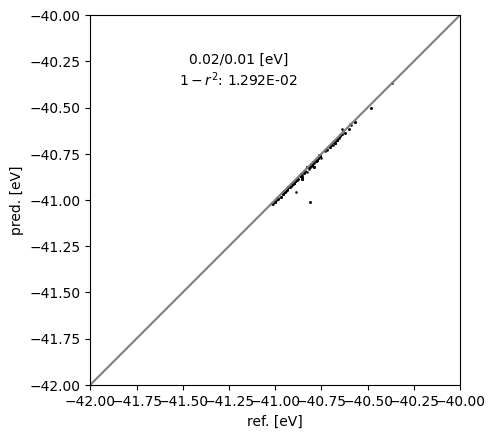

<Axes: xlabel='ref. [eV]', ylabel='pred. [eV]'>

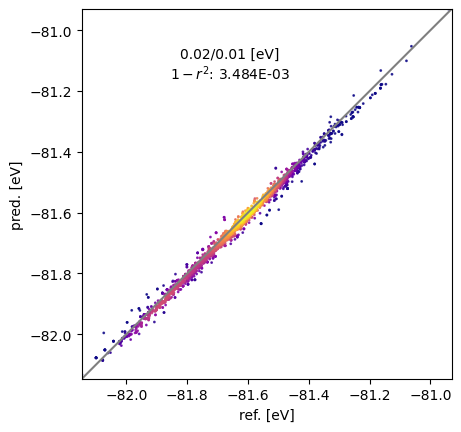

In [26]:
ax = plt.gca()
plot(Es[monomers_idx], predEs[monomers_idx], ax, units="eV", _property="", kde=False, s=1, diag=True)
plt.xlim(-42, -40)
plt.ylim(-42, -40)
plt.show()
ax = plt.gca()
plot(Es[dimers_idx], predEs[dimers_idx], ax, units="eV", _property="", kde=True, s=1, diag=True)

<Axes: xlabel='ref. [kcal/mol]', ylabel='pred. [kcal/mol]'>

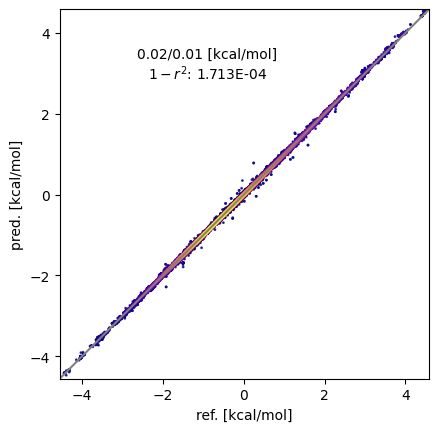

In [27]:
ax = plt.gca()
plot(Fs, predFs, ax, units="kcal/mol", _property="", kde=True, s=1, diag=True)

# Calculator

In [28]:
from mmml.pycharmmInterface.setupBox import *
import pycharmm
from mmml.pycharmmInterface.mmml_calculator import setup_calculator, CutoffParameters

In [29]:
?CutoffParameters

Init signature:
CutoffParameters(
    ml_cutoff: 'float' = 2.0,
    mm_switch_on: 'float' = 5.0,
    mm_cutoff: 'float' = 1.0,
)
Docstring:      Parameters for ML and MM cutoffs and switching functions
Init docstring:
Args:
    ml_cutoff: Distance where ML potential is cut off
    mm_switch_on: Distance where MM potential starts switching on
    mm_cutoff: Final cutoff for MM potential
File:           ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:           type
Subclasses:     

In [30]:
ATOMS_PER_MONOMER = 10
N_MONOMERS = 2

In [3]:
?setup_calculator

Object `setup_calculator` not found.


In [34]:
calculator_factory = setup_calculator(
    ATOMS_PER_MONOMER,
    N_MONOMERS,
    ml_cutoff_distance  = 2.0,
    mm_switch_on = 4.0,
    mm_cutoff  = 1.0,
    doML = True,
    doMM  = True,
    doML_dimer  = True,
    debug  = False,
    ep_scale = None,
    sig_scale = None,
    model_restart_path = "/home/ericb/mmml/mmml/physnetjax/ckpts/test-9af0d71b-4140-4d4b-83e3-ce07c652d048",
    MAX_ATOMS_PER_SYSTEM = 20,
)

all_monomer_idxs [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])]
all_dimer_idxs [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])]
0 1
dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 6.0    │ False │ False │ 128    │ 16     │ 0      │ 3     │ 20     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /home/ericb/mmml/mmml/physnetjax/ckpts/t… │ epoch-1000 │ 1000  │ Array gpu:0 0.033 │ 2025-09-16 14:27:43.060283 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

In [35]:
from ase.visualize.plot import plot_atoms
from mmml.pycharmmInterface import import_pycharmm
from mmml.pycharmmInterface.import_pycharmm import  *

In [36]:
from mmml.pycharmmInterface import setupRes, setupBox
from mmml.pycharmmInterface.import_pycharmm import reset_block, reset_block_no_internal
from mmml.pycharmmInterface.pycharmmCommands import CLEAR_CHARMM

CHARMM_HOME:  /home/ericb/mmml/setup/charmm
CHARMM_LIB_DIR:  /home/ericb/mmml/setup/charmm


In [37]:
CLEAR_CHARMM()
reset_block()
reset_block_no_internal()
reset_block()
reset_block()
reset_block_no_internal()
reset_block()

  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     DELETE PSF SELE ALL END
  
  
 CHARMM>     BLOCK
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ELEC Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of VDW Interac

In [38]:
initialize_psf("ACO", 2, 30, None)

  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     DELETE PSF SELE ALL END
  
  
 CHARMM>     read rtf card -
 CHARMM>     name /home/ericb/mmml/mmml/data/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/home/ericb/mmml/mmml/data/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /home

In [34]:
# mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [35]:
energy.show()


 SELECTED IMAGES ATOMS BEING CENTERED ABOUT  0.000000  0.000000  0.000000

 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSHIft   VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 14.000 CTEXNB =999.000 CTONNB = 10.000 CTOFNB = 12.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are      142 atom  pairs and       72 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
 ----------       ---------    ---------    ---------    ---------    ---------
ENER>        0     -0.00000     -0.00000      0.00000
 ----------       ---------    ---------    ---------    ---------    ---------


In [36]:
ase_atoms = ase_from_pycharmm_state()
R = ase_atoms.get_positions()
Z = ase_atoms.get_atomic_numbers()
R,Z

(array([[-2.492, 11.355,  3.291],
        [-1.748, 11.105,  2.35 ],
        [-1.104,  9.766,  2.193],
        [-1.431, 12.121,  1.305],
        [-1.599,  9.049,  2.888],
        [-1.228,  9.409,  1.154],
        [-0.03 ,  9.836,  2.446],
        [-2.38 , 12.553,  0.925],
        [-0.821, 12.93 ,  1.754],
        [-0.877, 11.654,  0.469],
        [14.882,  1.979,  5.346],
        [13.772,  1.47 ,  5.245],
        [13.599,  0.029,  4.89 ],
        [12.523,  2.256,  5.461],
        [14.584, -0.482,  4.987],
        [12.874, -0.443,  5.578],
        [13.245, -0.059,  3.846],
        [12.6  ,  2.792,  6.43 ],
        [12.41 ,  2.998,  4.646],
        [11.644,  1.584,  5.479]]),
 array([8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1]))

In [37]:
FACTOR = 1/(ase.units.kcal/ase.units.mol)
calcs = calculator_factory(atomic_numbers=Z, atomic_positions=R, n_monomers=2,
                           energy_conversion_factor=FACTOR, force_conversion_factor=FACTOR, 
                           debug=False
                          )

In [38]:
ase_atoms.calc = calcs[0]

In [39]:
ase_atoms.get_potential_energy()

  
 CHARMM>     read rtf card -
 CHARMM>     name /home/ericb/mmml/mmml/data/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/home/ericb/mmml/mmml/data/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /home/ericb/mmml/mmml/data/par_all36_cgenff.prm
 VOPEN> Attempting to open::/home/ericb/mmml

Array gpu:0 -4.368e+04

In [40]:
pycharmm_quiet()
pycharmm_verbose()

  
 CHARMM>     PRNLev 0
  
 CHARMM>    WRNLev 5
  


In [41]:
fix_idxs = np.array(range(20))
_fix_idxs = np.array(range(20))
fix_idxs[0] = _fix_idxs[3]
fix_idxs[3] = _fix_idxs[0]
fix_idxs[10] = _fix_idxs[13]
fix_idxs[13] = _fix_idxs[10]
batch_index = 0

In [42]:
test_R = valid_batches[batch_index]["R"][:20][fix_idxs]

In [43]:
test_Z = valid_batches[batch_index]["Z"][:20]
test_Z, test_Z[fix_idxs]

(array([6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1]),
 array([8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1]))

In [44]:
model.natoms = 20
model

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 6.0
    max_atomic_number = 16
    charges = False
    natoms = 20
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)

In [45]:
ref_physnet_atoms = ase.Atoms(test_Z[fix_idxs], test_R)
ref_physnet_atoms.calc = get_ase_calc(params_out, model, ref_physnet_atoms, {"energy": 1, "forces": 1}, ['energy', 'forces'])

['energy', 'forces']


In [46]:
ref_physnet_atoms.get_potential_energy()

Array gpu:0 -81.699

In [47]:
ref_physnet_F = ref_physnet_atoms.get_forces().flatten()

In [48]:
ref_e = valid_batches[batch_index]["E"][0][0]
ref_e

-81.72383238795156

In [49]:
ref_f = valid_batches[batch_index]["F"][:20]
refF = ref_f.flatten()

In [50]:
ase_atoms.set_positions(test_R)

In [51]:
ase_atoms.get_atomic_numbers()

array([8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1])

In [52]:
ase_atoms.get_potential_energy()

Array gpu:0 -4.336e+04

In [53]:
mF = np.array(ase_atoms.get_forces()).flatten()

In [54]:
ks = [
 'dH',
 'energy',
 'forces',
 'internal_E',
 'internal_F',
 'ml_2b_E',
 'ml_2b_F',
 'mm_E',
 'mm_F']
di = {}
for k in ks:
    di[k] = dict(ase_atoms.calc.results)["out"].__getattribute__(k).flatten()

In [55]:
dir(dict(ase_atoms.calc.results)["out"])
di

{'dH': Array[1] gpu:0 [-0.032],
 'energy': Array[1] gpu:0 [-1.880e+03],
 'forces': Array[60] x∈[-0.883, 0.613] μ=6.954e-09 σ=0.277 gpu:0,
 'internal_E': Array[1] gpu:0 [-1.880e+03],
 'internal_F': Array[60] x∈[-63.473, 65.992] μ=-0.051 σ=21.082 gpu:0,
 'ml_2b_E': Array[1] gpu:0 [0.],
 'ml_2b_F': Array[1] i32 gpu:0 [0],
 'mm_E': Array[1] gpu:0 [-0.032],
 'mm_F': Array[60] x∈[-0.883, 0.613] μ=6.954e-09 σ=0.277 gpu:0}

In [56]:
view_atoms(ref_physnet_atoms)

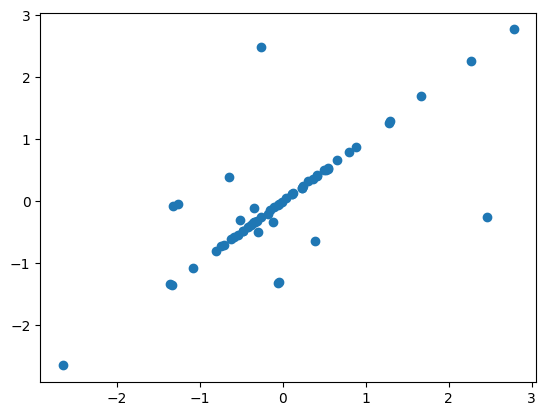

In [57]:
plt.scatter(refF, ref_physnet_F)

In [2]:
plt.scatter(mF,refF)

NameError: name 'plt' is not defined

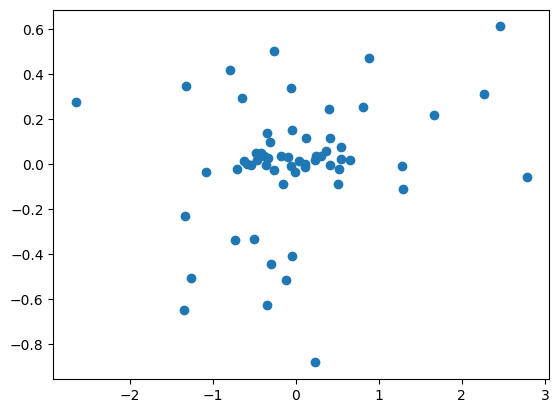

In [59]:
plt.scatter(refF,di["mm_F"])

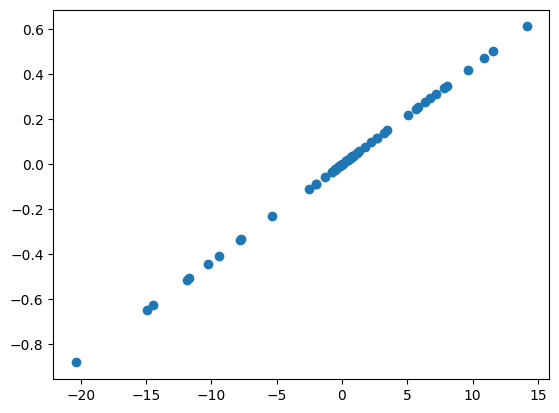

In [60]:
plt.scatter(mF,di["mm_F"])

In [61]:
np.array(dict(ase_atoms.calc.results)["out"].internal_E)*FACTOR + dict(ase_atoms.calc.results)["out"].mm_E

Array gpu:0 -4.336e+04

In [62]:
np.array(dict(ase_atoms.calc.results)["out"].internal_F)

array([[ -3.8562536 ,  -2.3601825 ,  11.02103   ],
       [-32.198063  ,  40.900707  ,  65.992     ],
       [-18.63509   , -17.097218  , -63.47265   ],
       [ 57.14108   , -28.83562   , -16.651426  ],
       [ 28.435747  ,   5.1133676 ,  -1.6187404 ],
       [ -5.246452  ,  -4.5104213 ,  -0.14703119],
       [ -7.6953216 ,   7.675352  ,   2.6289399 ],
       [-12.043946  ,  -2.9180493 , -13.993387  ],
       [-15.733238  ,  -9.668052  ,  14.642856  ],
       [  9.831538  ,  11.700125  ,   1.5984086 ],
       [-15.6027775 ,  -2.68322   ,  -0.7940702 ],
       [ 54.31881   ,  30.52579   ,  15.012596  ],
       [  2.683554  ,  16.446478  , -30.039843  ],
       [ -1.6655594 , -29.946842  ,  -1.0933452 ],
       [ -7.030444  , -22.043726  ,   6.8169236 ],
       [ -7.697053  ,  12.59433   ,   0.34963077],
       [  0.44067982,  -3.200391  ,  11.443743  ],
       [-16.53299   ,   9.329582  ,  -8.353364  ],
       [ -9.142596  ,  -0.91920763,   9.07165   ],
       [-10.121426  , -11.93298

In [63]:
view_atoms(ase_atoms)

In [33]:
setupRes.generate_residue("ACO ACO")
ic.build()
coor.show()

NameError: name 'setupRes' is not defined

In [65]:
test_R

array([[-5.558,  5.488, -6.71 ],
       [-7.51 ,  6.812, -6.577],
       [-6.579,  6.172, -8.7  ],
       [-6.492,  6.075, -7.252],
       [-7.675,  6.079, -9.007],
       [-5.95 ,  5.406, -9.183],
       [-6.15 ,  7.122, -9.058],
       [-7.642,  7.809, -7.014],
       [-7.032,  7.081, -5.621],
       [-8.469,  6.242, -6.475],
       [ 1.856,  0.269, -2.984],
       [ 2.504,  2.15 , -1.8  ],
       [ 0.426,  2.149, -3.312],
       [ 1.618,  1.445, -2.722],
       [ 0.426,  3.272, -3.177],
       [-0.456,  1.593, -2.962],
       [ 0.461,  2.01 , -4.424],
       [ 3.173,  1.431, -1.262],
       [ 1.992,  2.803, -1.093],
       [ 3.174,  2.864, -2.371]])

In [66]:
xyz = pd.DataFrame(test_R, columns=["x", "y", "z"])
coor.set_positions(xyz)

20

In [67]:
# energy.show()

In [68]:
# coor.show()

In [69]:
nbonds = """!#########################################
! Bonded/Non-bonded Options & Constraints
!#########################################

! Non-bonding parameters
nbonds atom cutnb 14.0  ctofnb 12.0 ctonnb 10.0 -
vswitch NBXMOD 3 -
inbfrq -1 imgfrq -1
"""
pycharmm.lingo.charmm_script(nbonds)

  
 CHARMM>     !#########################################
  
 CHARMM>    ! Bonded/Non-bonded Options & Constraints
 CHARMM>    !#########################################
 CHARMM>     
  
 CHARMM>    ! Non-bonding parameters
 CHARMM>    nbonds atom cutnb 14.0  ctofnb 12.0 ctonnb 10.0 -
 CHARMM>    vswitch NBXMOD 3 -
 CHARMM>    inbfrq -1 imgfrq -1

 <MKIMAT2>: updating the image atom lists and remapping
 Transformation   Atoms  Groups  Residues  Min-Distance
    1  N1Z0N1R1 has      10       1       1        7.68
    2  N1P1N1R1 has      10       1       1       10.71
    3  Z0Z0N1R1 has      20       2       2        6.91
    4  Z0P1N1R1 has      10       1       1       10.17
    5  N1Z0Z0R1 has      20       2       2        3.36
    6  Z0N1Z0R1 has      20       2       2        7.46
    8  N1Z0P1R1 has       0       0       0       12.14
 Total of  110 atoms and   11 groups and   11 residues were included


 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSHIft   

1

In [70]:
pycharmm_quiet()
energy.show()

  
 CHARMM>     PRNLev 0


In [71]:
energy.get_term_by_name("VDW")

1.984e-320

In [72]:
energy.get_term_by_name("ELEC")

-1.5687e-320

In [32]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [74]:
pycharmm_verbose()
energy.show()

  
 CHARMM>    WRNLev 5
  

 <MKIMAT2>: updating the image atom lists and remapping
 Transformation   Atoms  Groups  Residues  Min-Distance
    1  N1Z0N1R1 has      10       1       1        7.68
    2  N1P1N1R1 has      10       1       1       10.71
    3  Z0Z0N1R1 has      20       2       2        6.91
    4  Z0P1N1R1 has      10       1       1       10.17
    5  N1Z0Z0R1 has      20       2       2        3.36
    6  Z0N1Z0R1 has      20       2       2        7.46
    8  N1Z0P1R1 has       0       0       0       12.14
 Total of  110 atoms and   11 groups and   11 residues were included

 <MAKGRP> found      0 image group exclusions.

 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSHIft   VATOm    VSWItch 
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 14.000 CTEXNB =999.000 CTONNB = 10.000 CTOFNB = 12.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      3
 There are      141 atom  pairs and       48 a

In [39]:
CLEAR_CHARMM()

  
 CHARMM>     DELETE ATOM SELE ALL END
 SELRPN>     20 atoms have been selected out of     20

 Message from MAPIC: Atom numbers are changed.

 Message from MAPIC:          2 residues deleted.

 Message from MAPIC:          1 segments deleted.
 DELTIC:        18 bonds deleted
 DELTIC:        30 angles deleted
 DELTIC:        24 dihedrals deleted
 DELTIC:         2 improper dihedrals deleted
 DELTIC:         2 acceptors deleted

      ***** LEVEL  0 WARNING FROM <CLIMAG> *****
      ***** PSF modified with image centering active: Now off.
      ******************************************
      BOMLEV ( -2) IS NOT REACHED. WRNLEV IS  4

 PSFSUM> PSF modified: NONBOND lists and IMAGE atoms cleared.
 PSFSUM> Summary of the structure file counters :
         Number of segments      =        0   Number of residues   =        0
         Number of atoms         =        0   Number of groups     =        0
         Number of bonds         =        0   Number of angles     =        0
         N

In [40]:
atoms = setupRes.main("ACO")

***** Generating residue from residue name (ACO) *****
***** Generating residue *****
  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     read rtf card -
 CHARMM>     name /home/ericb/mmml/mmml/data/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/home/ericb/mmml/mmml/data/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>   

In [41]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()

***** Generating coordinates *****

          COORDINATE FILE MODULE
 TITLE>  * EXECUTING CHARMM SCRIPT FROM PYTHON
 TITLE>  *  DATE:     9/17/25      0:26:21      CREATED BY USER: ericb
 TITLE>  *
        10  EXT
         1         1  ACO       O1              0.0649998909        0.2734351930        1.0223437886  ACO       1               0.0000000000
         2         1  ACO       C1              0.5508244730        1.1591257857        0.5209579166  ACO       1               0.0000000000
         3         1  ACO       C2              0.1759143246        0.0569765759        0.3503809683  ACO       1               0.0000000000
         4         1  ACO       C3              0.1776270934        0.8440479784        0.0485853083  ACO       1               0.0000000000
         5         1  ACO       H21             0.0623199405        0.7714123306        0.3425868534  ACO       1               0.0000000000
         6         1  ACO       H22             1.1950341453        0.5993923027 

In [42]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [43]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()


***** Generating coordinates *****

          COORDINATE FILE MODULE
 TITLE>  * EXECUTING CHARMM SCRIPT FROM PYTHON
 TITLE>  *
        10  EXT
         1         1  ACO       O1              0.4403522179        1.3124076320        0.4876340973  ACO       1               0.0000000000
         2         1  ACO       C1              0.2617934186        0.5262974487        1.0728227707  ACO       1               0.0000000000
         3         1  ACO       C2              0.7750723367        0.5777249264        0.9868055817  ACO       1               0.0000000000
         4         1  ACO       C3              0.8099992021        0.6237859448        1.0257711000  ACO       1               0.0000000000
         5         1  ACO       H21             0.0002101173        0.1547580523        1.0051868569  ACO       1               0.0000000000
         6         1  ACO       H22             0.6423699530        0.1783572797        0.4520510429  ACO       1               0.0000000000
         7 

In [44]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [45]:
energy.show()


 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSWItch  VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 18.000 CTEXNB =999.000 CTONNB = 13.000 CTOFNB = 17.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are       21 atom  pairs and       36 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
 PRNHBD: CUToff Hydrogen Bond  distance =    0.5000   Angle =   90.0000
         CuT switching ON HB dist. =     3.5000  OFf HB dist. =    4.0000
         CuT switching ON Hb Angle =    50.0000  OFf Hb Angle =   70.0000
         ACCEptor antecedents included
         All hydrogen bonds for each hydrogen will be found
         Hydrogen bonds between excluded atoms will be kept

ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
ENER INTERN:          BONDs       ANGLes       UREY-b    DIHEdrals    IMPRopers
ENER EXTERN:        VDWaals         ELEC       HBONds  

In [46]:
energy.get_term_by_name("VDW")

-0.2587105242449861

In [47]:
pycharmm.lingo.get_energy_value("ENER")

-29.56339253212626

# Example: packmol for a dimer system

In [49]:
run_packmol(20, 30)

~/mmml/mmml/packmol/packmol < packmol/packmol.inp

################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                             Version 21.1.0 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Types of coordinate files specified: pdb
  Seed for random number generator:       176242
  Output file: pdb/init-packmol.pdb
  Reading coordinate file: pdb/initial.pdb
  Number of independent structures:            1
  The structures are: 
  Structure            1 :pdb/initial.pdb(          10  atoms)
  Maximum number of GENCAN loops for all molecule packing:          200
  Distance tolerance:    2.0000000000000000     
  Re

In [85]:
def CLEAR_CHARMM():
    s = """DELETE ATOM SELE ALL END"""
    pycharmm.lingo.charmm_script(s)
    s = """DELETE PSF SELE ALL END"""
    pycharmm.lingo.charmm_script(s)

CLEAR_CHARMM()

  
 CHARMM>     DELETE ATOM SELE ALL END
 SELRPN>     10 atoms have been selected out of     10

 Message from MAPIC: Atom numbers are changed.

 Message from MAPIC:          1 residues deleted.

 Message from MAPIC:          1 segments deleted.
 DELTIC:         9 bonds deleted
 DELTIC:        15 angles deleted
 DELTIC:        12 dihedrals deleted
 DELTIC:         1 improper dihedrals deleted
 DELTIC:         1 acceptors deleted
 PSFSUM> PSF modified: NONBOND lists and IMAGE atoms cleared.
 PSFSUM> Summary of the structure file counters :
         Number of segments      =        0   Number of residues   =        0
         Number of atoms         =        0   Number of groups     =        0
         Number of bonds         =        0   Number of angles     =        0
         Number of dihedrals     =        0   Number of impropers  =        0
         Number of cross-terms   =        0   Number of autogens   =        0
         Number of HB acceptors  =        0   Number of HB donors

In [86]:
reset_block()
reset_block_no_internal()
reset_block()
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

  
 CHARMM>     BLOCK
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ELEC Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of VDW Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 

In [87]:
# pycharmm_verbose()

In [1]:
# pycharmm.lingo.charmm_script(nbonds)

# #equivalent CHARMM scripting command: minimize abnr nstep 1000 tole 1e-3 tolgr 1e-3
# minimize.run_abnr(nstep=1000, tolenr=1e-1, tolgrd=1e-1)
# #equivalent CHARMM scripting command: energy
# energy.show()

In [ ]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
ase_atoms.set_positions(coor.get_positions())
view_atoms(ase_atoms)

In [85]:
cs

In [86]:
ase_atoms.get_potential_energy()

Array gpu:0 -4.367e+04

In [87]:
ase_atoms.calc.results #["out"]

{'out': ModelOutput(energy=Array gpu:0 -1.894e+03, forces=Array[20, 3] n=60 x∈[-0.381, 0.374] μ=1.490e-09 σ=0.131 gpu:0, dH=Array gpu:0 0., internal_E=Array gpu:0 -1.894e+03, internal_F=Array[20, 3] n=60 x∈[-23.245, 21.674] μ=-0.069 σ=8.313 gpu:0, mm_E=Array gpu:0 0., mm_F=Array[20, 3] n=60 x∈[-0.381, 0.374] μ=1.490e-09 σ=0.131 gpu:0, ml_2b_E=Array gpu:0 0., ml_2b_F=Array i32 gpu:0 0),
 'energy': Array gpu:0 -4.367e+04,
 'forces': Array[20, 3] n=60 x∈[-8.795, 8.634] μ=1.589e-08 σ=3.032 gpu:0}

In [88]:
ase_atoms.calc.results["out"].mm_E

Array gpu:0 0.

In [89]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms).run(fmax=0.001)

      Step     Time          Energy          fmax
BFGS:    0 15:14:59   -43671.195312        9.591309
BFGS:    1 15:14:59   -42012.757812       10.689807
BFGS:    2 15:14:59   -38841.722656       12.441577
BFGS:    3 15:14:59   -36181.445312       14.392749
BFGS:    4 15:14:59   -36831.097656       16.569622
BFGS:    5 15:14:59   -35262.066406       19.004224
BFGS:    6 15:14:59   -47416.445312       21.735415
BFGS:    7 15:14:59   -35564.015625       24.810569
BFGS:    8 15:14:59   -19419.623047       28.287595
BFGS:    9 15:14:59   -35282.742188       32.237459
BFGS:   10 15:14:59   -42526.101562       36.747989
BFGS:   11 15:14:59   -30677.730469       41.928412
BFGS:   12 15:14:59   -36193.046875       47.916278
BFGS:   13 15:14:59   -38577.375000       54.886624
BFGS:   14 15:14:59   -35955.296875       63.065231
BFGS:   15 15:14:59   -35813.203125       72.746906
BFGS:   16 15:14:59   -35575.105469       84.319582
BFGS:   17 15:14:59   -37103.691406       98.286874
BFGS:   18 15:


KeyboardInterrupt



In [90]:
view_atoms(ase_atoms)

In [161]:
# Parameters.
temperature = 10
timestep_fs = 0.1
num_steps = 300

# Draw initial momenta.
MaxwellBoltzmannDistribution(ase_atoms, temperature_K=temperature)
Stationary(ase_atoms)  # Remove center of mass translation.
ZeroRotation(ase_atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(ase_atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(ase_atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = ase_atoms.get_positions()
  potential_energy[i] = ase_atoms.get_potential_energy()
  kinetic_energy[i] = ase_atoms.get_kinetic_energy()
  total_energy[i] = ase_atoms.get_total_energy()
  # Occasionally print progress.
  if i % 100 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -90.556 ekin  0.024 etot -90.532
step   100 epot -79.673 ekin  0.024 etot -79.648
step   200 epot -75.791 ekin  0.025 etot -75.767


In [162]:
# # Visualize the structure with py3Dmol.
# view = py3Dmol.view()
# xyz = io.StringIO()
# ase_io.write(xyz, ase_atoms, format='xyz')
# view.addModel(xyz.getvalue(), 'xyz')
# view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
# view.show()
# view.getModel().setCoordinates(frames[::100], 'array')
# view.animate({'loop': 'forward', 'interval': 0.1})
# view.show() 

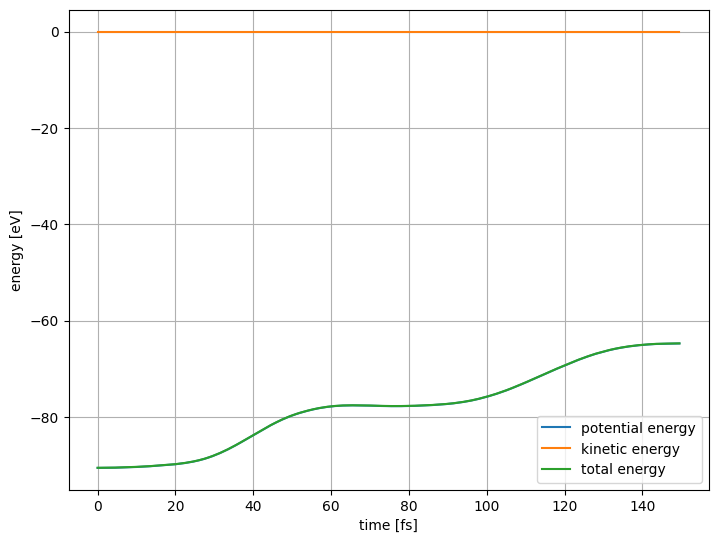

In [163]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()

In [164]:
view_atoms(ase_atoms)